# Load data

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
from result_saver import SaverProvider
provider = SaverProvider()

In [5]:
import numpy as np
from Scratch import metadata_loader

md = metadata_loader(_extract=True, _drop_inutile=True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["notebook_name"] == "bigger_rep_codes"]
max_distance = int(max(md.distance))
max_distance = 10
md = md[md["distance"] == max_distance]
md = md.sort_values(by='backend_name', ascending=False)

md = md[:2]

md

,creation_date,notebook_name,backend_name,job_id,tags,shots,tags_xp,sampled_state,num_qubits,job_status,extra,optimization_level,code,distance,rounds,logical,layout,descr
51,2023-10-29 14:43:41.752908+01:00,bigger_rep_codes,ibm_sherbrooke,cmz633cvayrg008sp2a0,[],10000.0,NaN,NaN,NaN,JobStatus.DONE,NaN,NaN,RepetitionCodeCircuit,10.0,10,0,_is_hex=True,Run bigger Repetition codes
242,2023-10-30 09:43:20.984078+01:00,bigger_rep_codes,ibm_sherbrooke,cmzpsa5vayrg008cpk30,[],10000.0,NaN,NaN,NaN,JobStatus.DONE,NaN,NaN,RepetitionCodeCircuit,10.0,10,0,_is_hex=True,Run bigger Repetition codes v4: new distances ...


In [6]:
memories = {}
for job_id, logical in zip(md.job_id, md.logical):
    mmr_name = f"mmr_log_{logical}"
    memories[mmr_name] = provider.retrieve_job(job_id).result().get_memory()

memories

{'mmr_log_0': array([[-1.69043800e+07+1.52777920e+07j, -6.95536570e+07+3.97118220e+07j,
         -8.61951720e+07-6.66768820e+07j, ...,
         -1.11575833e+08-8.60894400e+07j,  3.03813270e+07+6.08026020e+07j,
         -4.81019930e+07-6.95120170e+07j],
        [-1.93997510e+07+1.77208380e+07j, -5.59600780e+07+6.58611030e+07j,
         -6.72833050e+07-6.30488450e+07j, ...,
          6.76670320e+07-9.64343640e+07j,  4.18878580e+07+3.72742840e+07j,
         -4.42934960e+07-5.69044300e+07j],
        [-2.02618610e+07+2.40441530e+07j, -5.47100890e+07+6.68740870e+07j,
         -7.64413350e+07-7.37752260e+07j, ...,
         -1.11808223e+08-9.38663590e+07j, -3.56569670e+07+6.30416770e+07j,
         -4.44256210e+07-5.80749620e+07j],
        ...,
        [-1.25824540e+07+1.02028210e+07j,  3.95282030e+07+7.85776400e+07j,
         -8.98716200e+07-6.66634720e+07j, ...,
          6.82267440e+07-9.14290790e+07j, -4.78136750e+07+7.53373550e+07j,
         -4.03697040e+07-3.61357170e+07j],
        [-1.14

# Decode

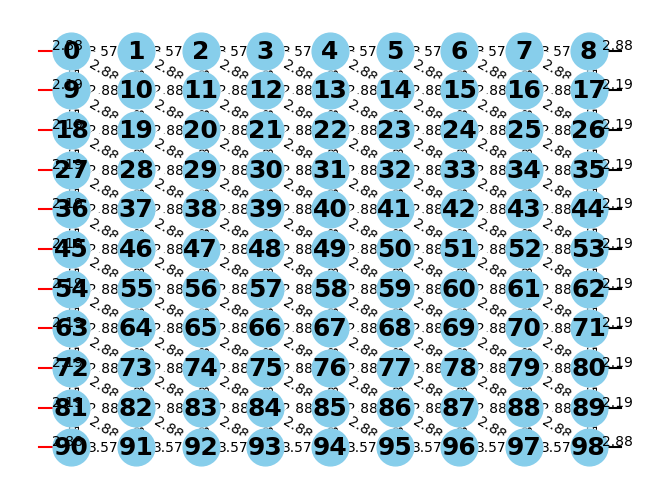

In [7]:
import numpy as np
import stim
import pymatching

from soft_info import get_repcode_layout, get_KDEs, draw_matching_graph

# Code parameters
max_distance = 10
d=max_distance
T=max_distance
layout = get_repcode_layout(distance=max_distance, backend=provider.get_backend("ibm_sherbrooke"), _is_hex=True)

kde_dict, scaler_dict = get_KDEs(provider, 'ibm_sherbrooke', layout, bandwidths=0.2, plot=False)

circuit = stim.Circuit.generated("repetition_code:memory",
                                 distance=d,
                                 rounds=T,
                                 after_clifford_depolarization=0.1)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

memory = memories['mmr_log_0']
draw_matching_graph(matching, d, T)


---- New edge ----
0 None {'fault_ids': set(), 'weight': 2.8763855159214238, 'error_probability': 0.05333333333333338}

---- New edge ----
0 1 {'fault_ids': set(), 'weight': 3.568738257010482, 'error_probability': 0.02741843737473918}

---- New edge ----
0 9 {'fault_ids': set(), 'weight': 3.568738257010482, 'error_probability': 0.02741843737473918}

---- New edge ----
0 10 {'fault_ids': set(), 'weight': 2.876385515921424, 'error_probability': 0.05333333333333336}

---- New edge ----
1 2 {'fault_ids': set(), 'weight': 3.568738257010482, 'error_probability': 0.02741843737473918}

---- New edge ----
1 10 {'fault_ids': set(), 'weight': 2.876385515921424, 'error_probability': 0.05333333333333336}

---- New edge ----
1 11 {'fault_ids': set(), 'weight': 2.876385515921424, 'error_probability': 0.05333333333333336}

---- New edge ----
2 3 {'fault_ids': set(), 'weight': 3.568738257010482, 'error_probability': 0.02741843737473918}

---- New edge ----
2 11 {'fault_ids': set(), 'weight': 2.8763855

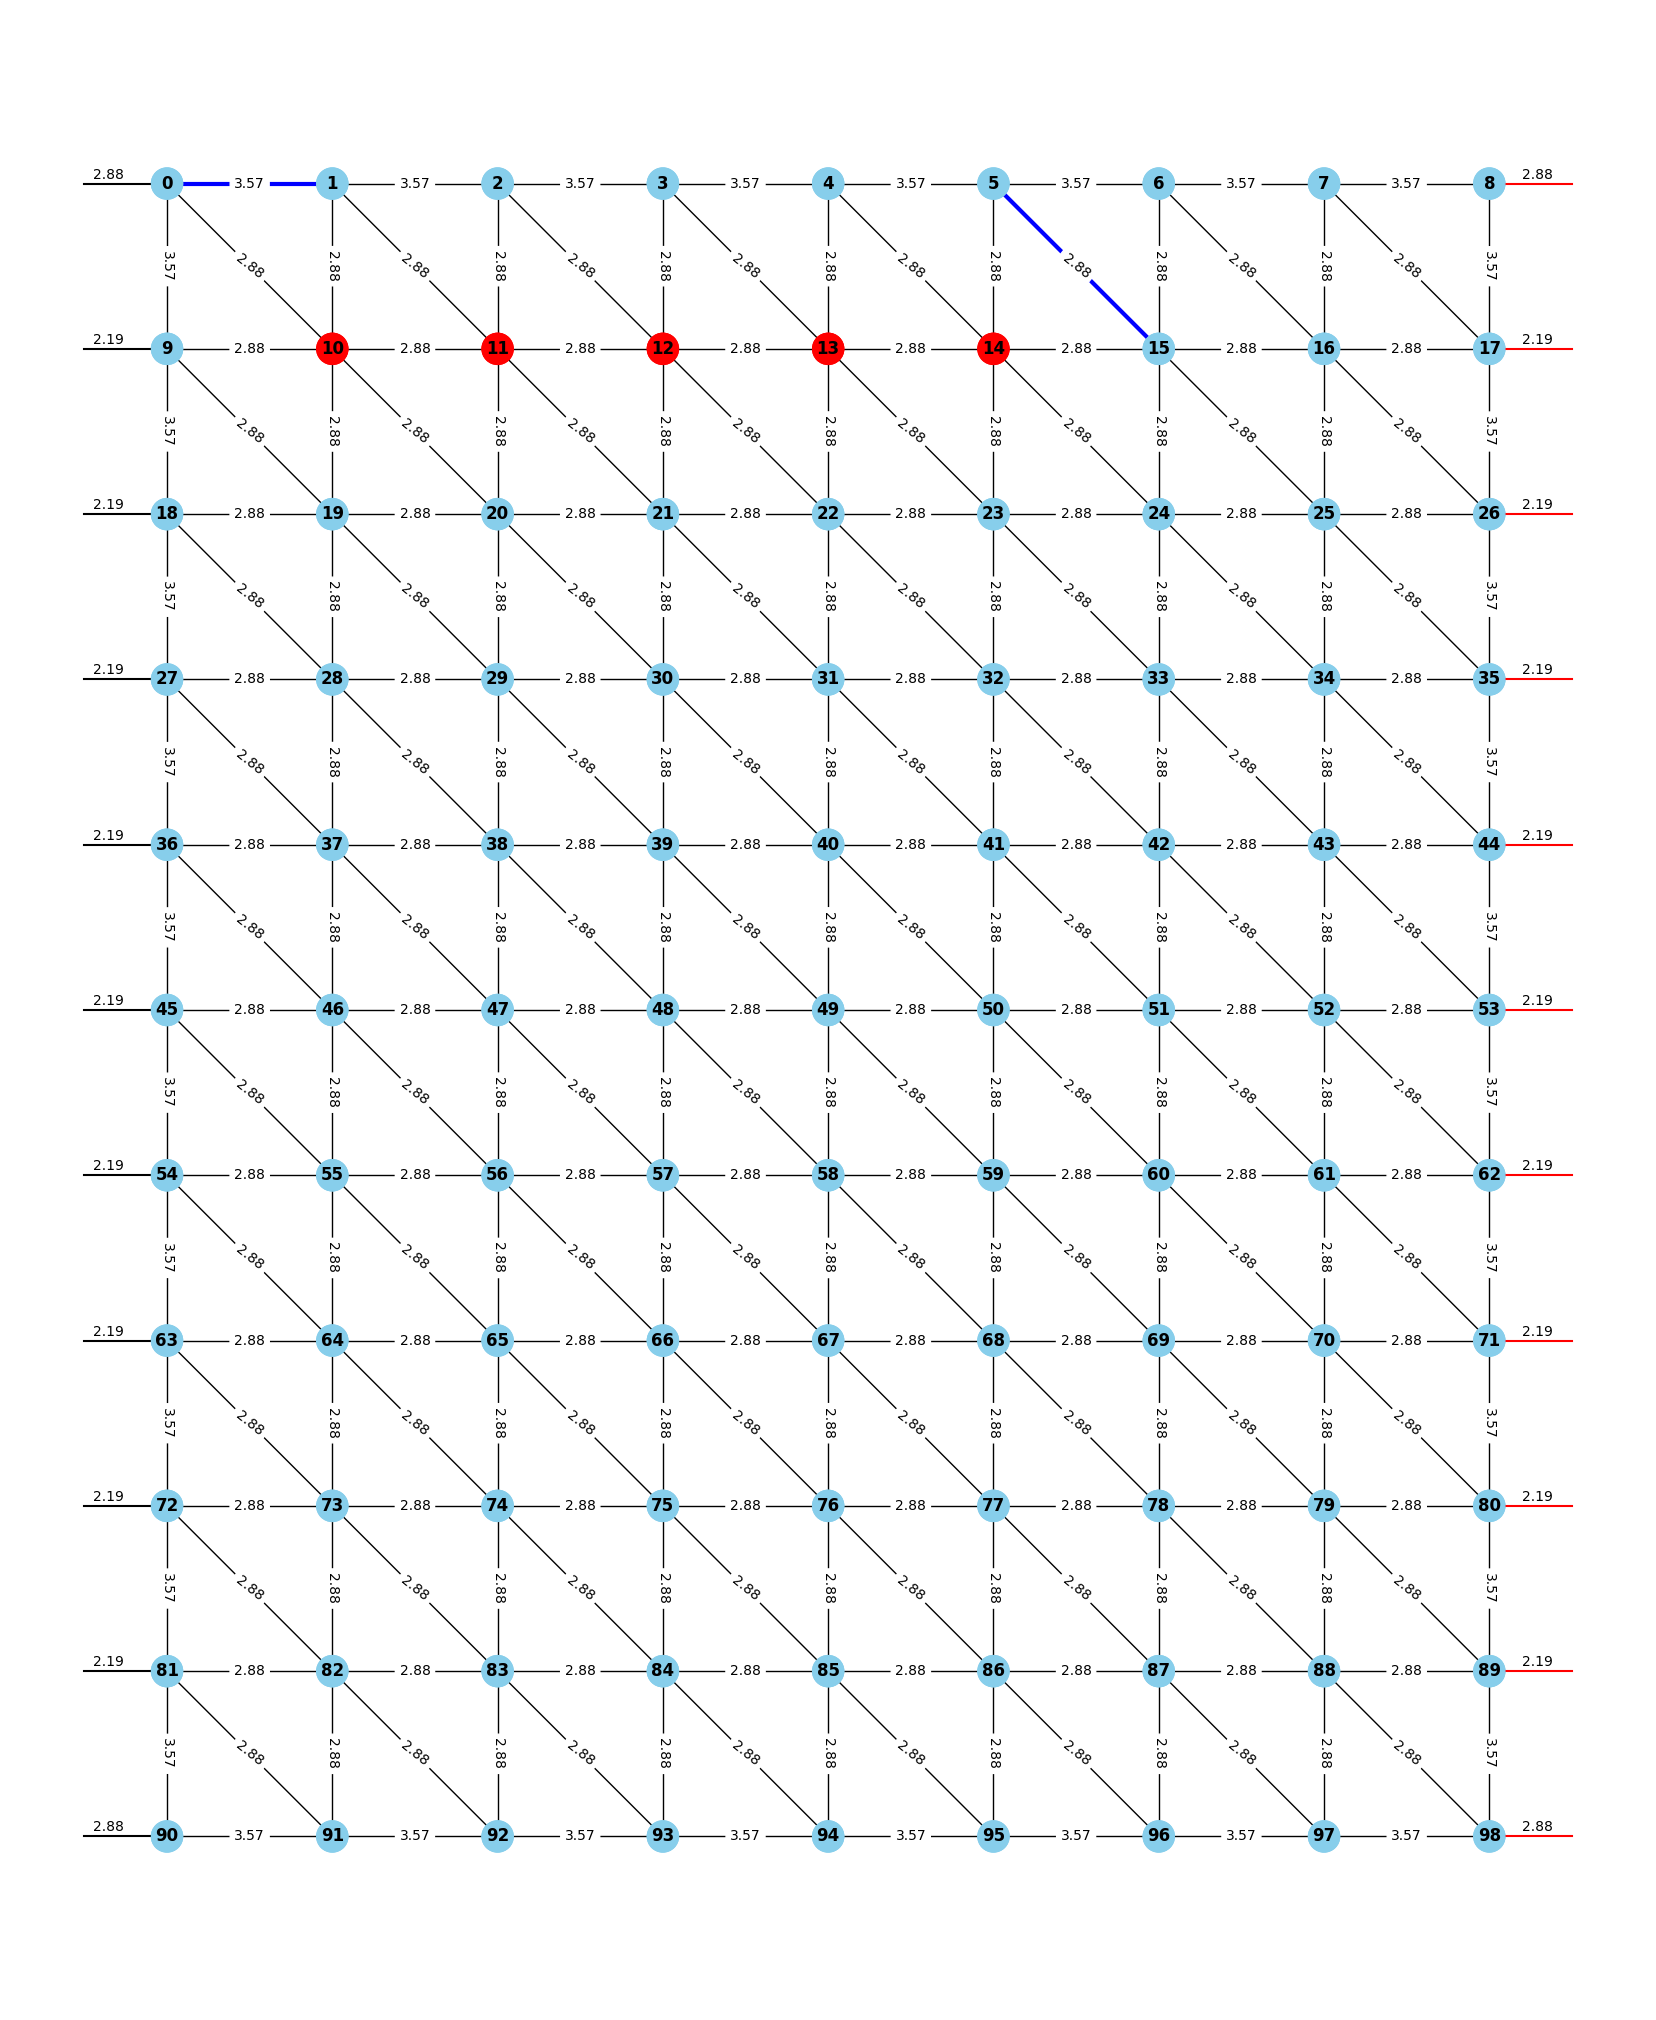

In [15]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_matching_graph(matching, d, T, syndromes=None, matched_edges=None, figsize=(8, 6)):
    G = nx.Graph()
    pos = {}
    edge_colors = []
    edge_widths = []
    node_colors = []

    # Define normal and highlighted edge widths
    normal_edge_width = 1
    highlighted_edge_width = 3

    # Add all nodes to the graph with their positions and initial colors
    for i in range((d-1)*(T+1)):
        x_pos = i % (d-1)
        y_pos = i // (d-1)
        G.add_node(i)  # Explicitly add the node
        pos[i] = (x_pos, -y_pos)
        if syndromes and syndromes[i] == 1:
            node_colors.append('red')
        else:
            node_colors.append('skyblue')
    
    # Add edges to the graph
    for edge in matching.edges():
        print("\n---- New edge ----")
        src_node, tgt_node, edge_data = edge
        print(src_node, tgt_node, edge_data)
        if tgt_node is not None:
            G.add_edge(src_node, tgt_node, weight=edge_data['weight'])
            if matched_edges and ([src_node, tgt_node] in matched_edges or [tgt_node, src_node] in matched_edges):
                edge_colors.append('blue')
                edge_widths.append(highlighted_edge_width)
            else:
                edge_colors.append('black')
                edge_widths.append(normal_edge_width)
        else:
            # Handle dangling edges
            pass  # Your existing logic for dangling edges can be included here
    
    # Draw the graph
    plt.figure(figsize=figsize)
    nx.draw(G, pos, labels={node: node for node in G.nodes()}, with_labels=True, 
            node_color=node_colors, edge_color=edge_colors, width=edge_widths, 
            font_weight='bold', node_size=500, font_size=12)

    # Draw edge weights
    edge_weights = nx.get_edge_attributes(G, 'weight')
    edge_labels = {edge: f"{weight:.2f}" for edge, weight in edge_weights.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    for edge in matching.edges():
        src_node, tgt_node, edge_data = edge
        if tgt_node is None:
            x_src = src_node % (d-1)
            y_src = src_node // (d-1)
            color = 'r' if edge_data.get('fault_ids') else 'k'
            weight_text = f"{edge_data['weight']:.2f}" if 'weight' in edge_data else ""
            if x_src == 0:
                plt.plot([x_src, x_src - 0.5], [-y_src, -y_src], color=color)
                plt.text(x_src - 0.45, -y_src + 0.03, weight_text, fontsize=10)
            elif x_src == d - 2:
                plt.plot([x_src, x_src + 0.5], [-y_src, -y_src], color=color)
                plt.text(x_src + 0.2, -y_src + 0.03, weight_text, fontsize=10)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)

    plt.axis('scaled')
    plt.show()

# Example usage
syndrome = [0]*10 + [1]*5 + [0]*100
matched_edges = [[0,1], [5, 15]]
draw_matching_graph(matching, d, T, syndromes=syndrome, matched_edges=matched_edges, figsize=(20, 20))


[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


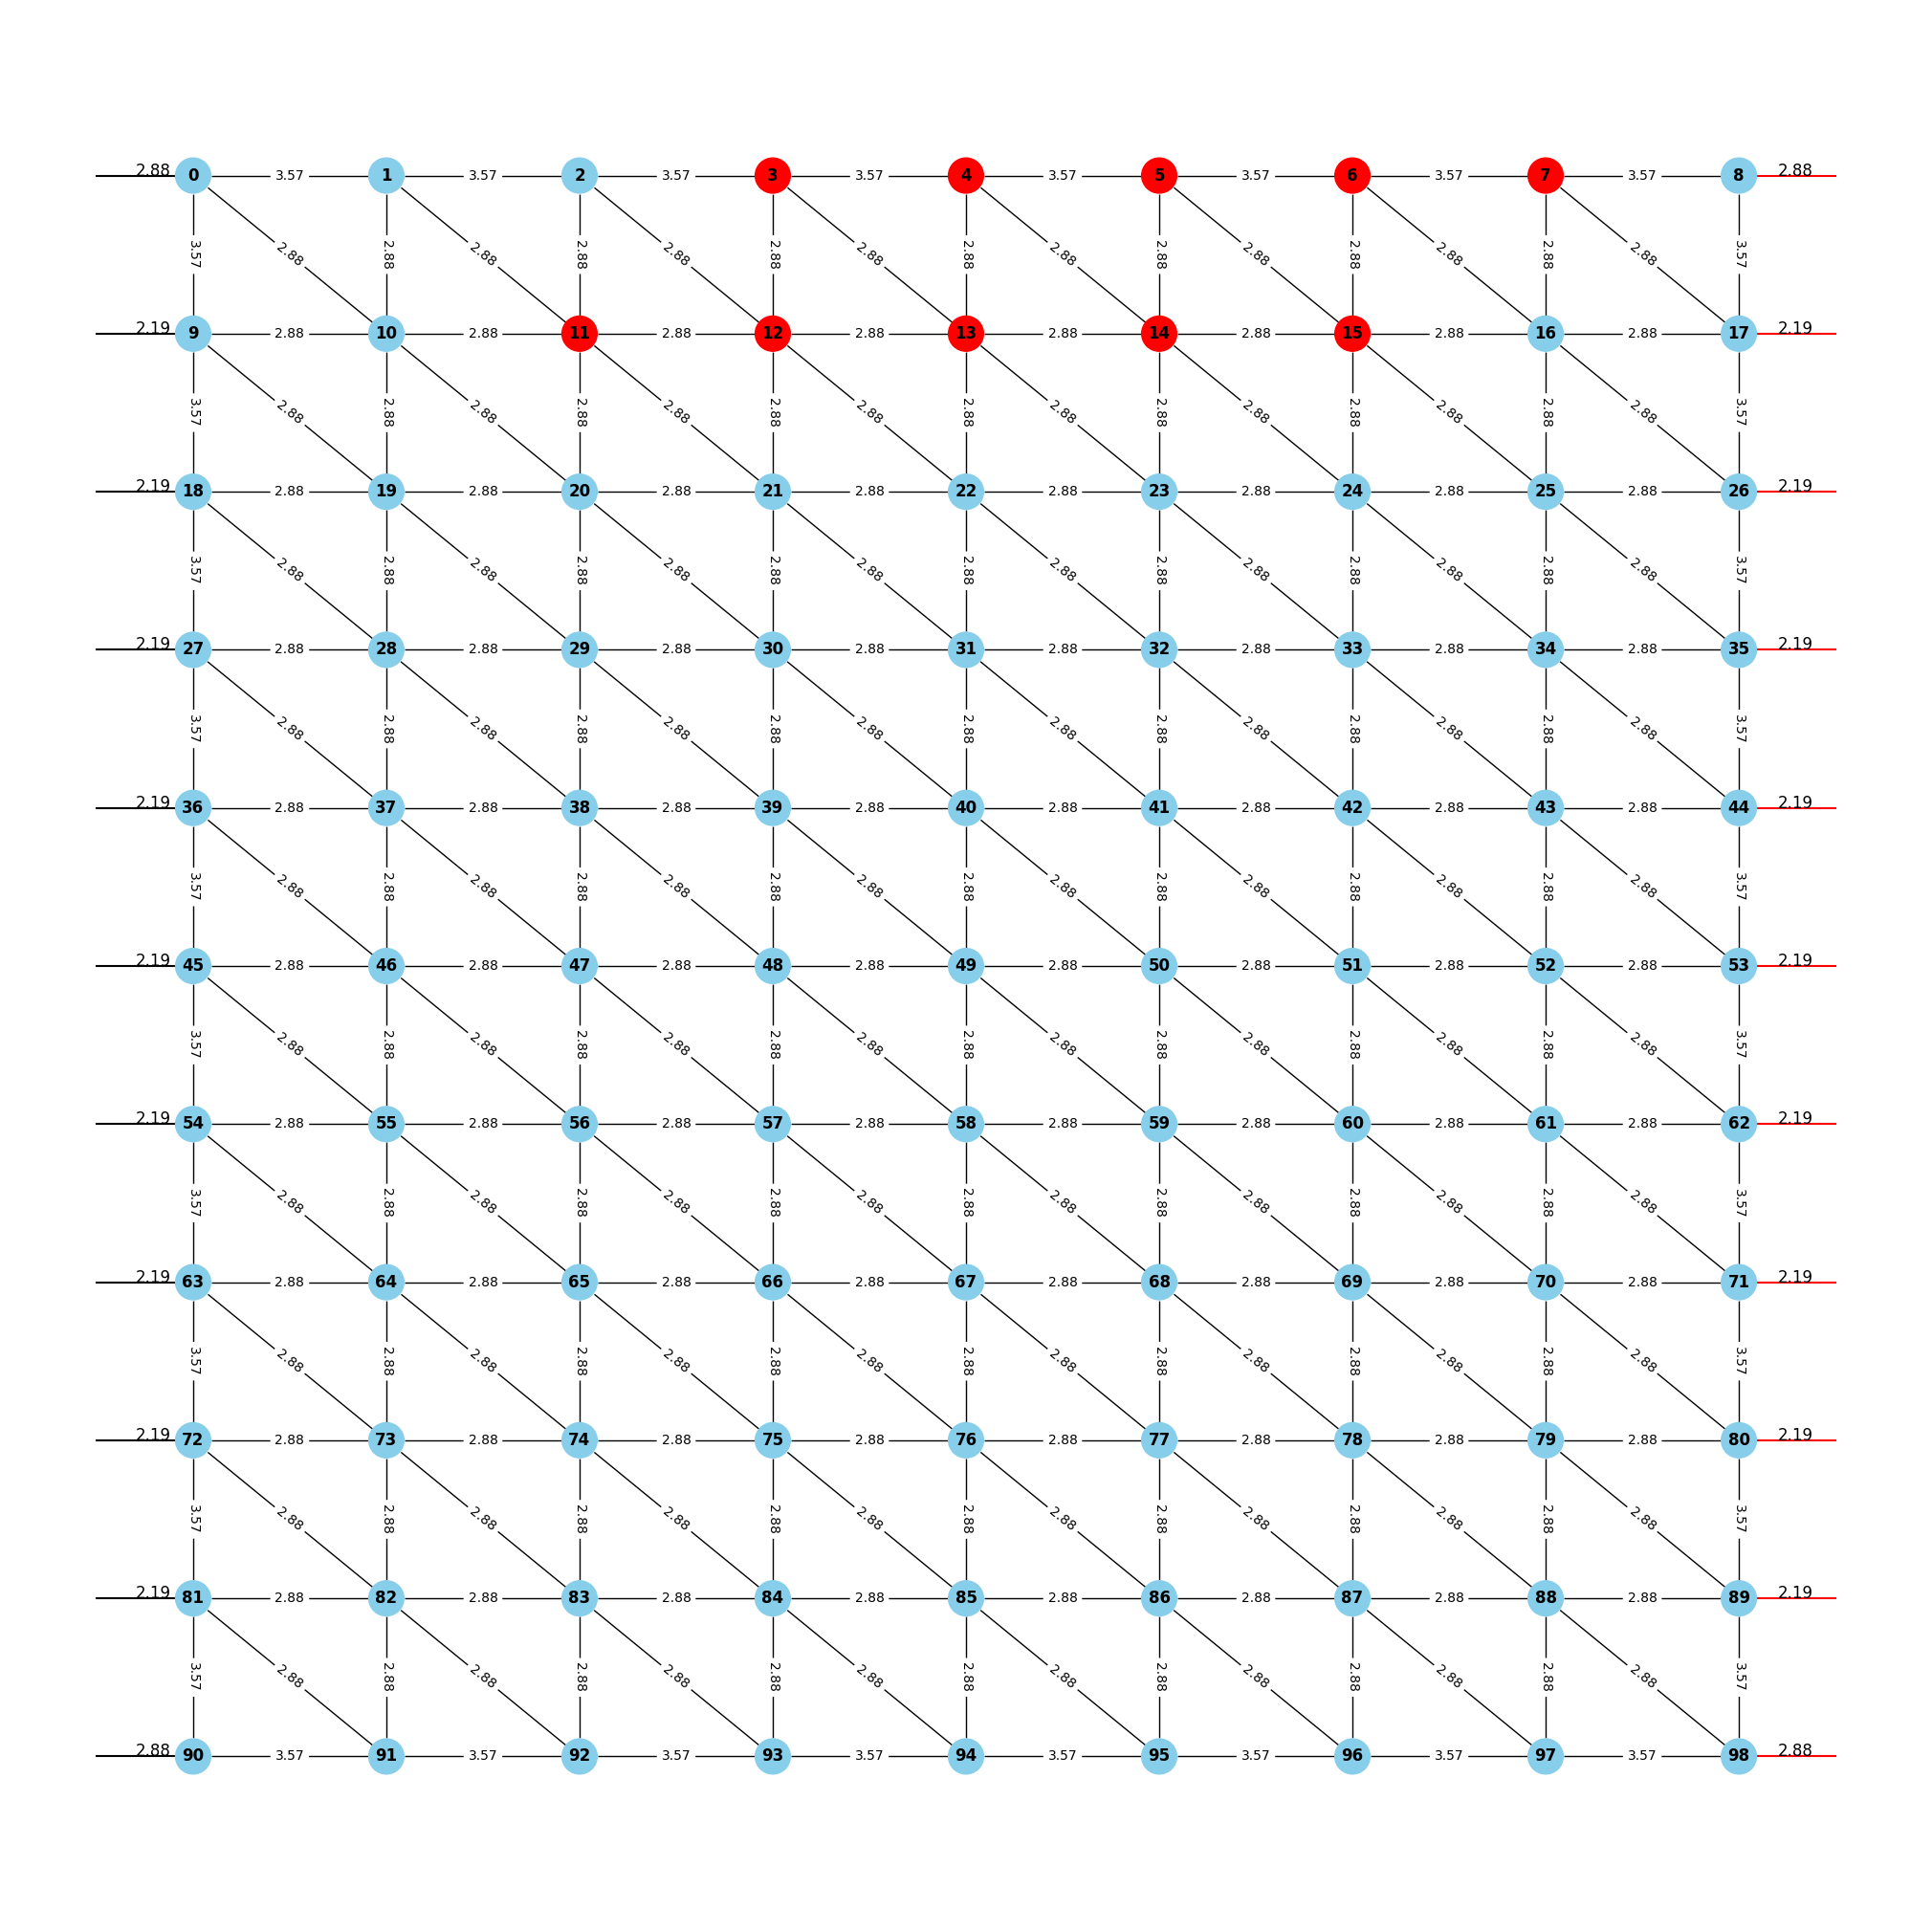

In [43]:
# OLD PLOT FUNC

import matplotlib.pyplot as plt
import networkx as nx

def draw_matching_graph(matching, d, T, syndrome = None, figsize=(8, 6)):
    G = nx.Graph()
    pos = {}
    edge_colors = []
    node_colors = []

    for i in range((d-1)*(T+1)):
        if syndrome and syndrome[i] == 1:
            node_colors.append('red')
        else:
            node_colors.append('skyblue')
    
    for edge in matching.edges():
        src_node, tgt_node, edge_data = edge
        if tgt_node is not None:
            G.add_edge(src_node, tgt_node, weight=edge_data['weight'])
            edge_colors.append('r' if edge_data.get('fault_ids') else 'k')

        # Node positions are kept without scaling
        x_src = src_node % (d-1)
        y_src = src_node // (d-1)
        pos[src_node] = (x_src, -y_src)

    # Create a figure with the specified size
    plt.figure(figsize=figsize)

    # Draw the graph with original node and font sizes
    nx.draw(G, pos, with_labels=True, node_color='white',
            edge_color=edge_colors, font_weight='bold', node_size=700, font_size=12)

    # Draw edge labels with original font size
    edge_weights = nx.get_edge_attributes(G, 'weight')
    labels = {k: f"{v:.2f}" for k, v in edge_weights.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    # Handle dangling edges and weights for nodes without a target
    for edge in matching.edges():
        src_node, tgt_node, edge_data = edge
        if tgt_node is None:
            x_src = src_node % (d-1)
            y_src = src_node // (d-1)
            color = 'r' if edge_data.get('fault_ids') else 'k'
            weight_text = f"{edge_data['weight']:.2f}" if 'weight' in edge_data else ""
            if x_src == 0:
                plt.plot([x_src, x_src - 0.5], [-y_src, -y_src], color=color)
                plt.text(x_src - 0.3, -y_src, weight_text, fontsize=12)
            elif x_src == d - 2:
                plt.plot([x_src, x_src + 0.5], [-y_src, -y_src], color=color)
                plt.text(x_src + 0.2, -y_src, weight_text, fontsize=12)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=700)

    #plt.axis('scaled')  # Keeps the aspect ratio square.
    plt.show()

# Example usage:
syndromes = [0]*5 + [1]*10 + [0]*100
print(syndromes)
draw_matching_graph(matching, d, T, syndrome=syndromes, figsize=(20, 20))


# Load functions

In [12]:
from tqdm import tqdm

from soft_info import get_counts, soft_reweight_pymatching, count_string_to_syndromes

VERBOSE = False

actual_observables = np.array([[False]]) # hardcoded, can be retrieved
num_errors = 0

i = 0
w_idx_lst = []
for shot in tqdm(range(len(memory))[:100]):
    i += 1
    IQ_data = memory[shot]

    counts = get_counts([IQ_data], kde_dict, scaler_dict, layout, T, verbose=False)
    count_key = next(iter(counts.keys()))
    
    soft_reweight_pymatching(matching, d, T, IQ_data, kde_dict, layout, scaler_dict, common_measure=0.01, verbose=False)  

    array_processed_string = count_string_to_syndromes(count_key, verbose=False)

    predicted_observables = matching.decode(array_processed_string)

    if predicted_observables == [0]:
        continue
    
    #print(f"Wrong decoding at index {i}")
    w_idx_lst.append(i)

    
    if VERBOSE:
        print("Count key:", count_key)
        print("count_string_to_syndromes:", array_processed_string)

    if VERBOSE:
        draw_matching_graph(matching, d, T)

    if VERBOSE:
        matched_edges = matching.decode_to_edges_array(array_processed_string)
        print("matched_edges: ", matched_edges)
        print("Estimated flip:", predicted_observables)

    num_errors += not np.array_equal(actual_observables[0, :], predicted_observables) # 0 can be changed to i if multiple observables and multiple syndromes per ovbservable

print("Num errors:", num_errors)

100%|██████████| 100/100 [00:31<00:00,  3.13it/s]

Num errors: 25


In [14]:
from tqdm import tqdm

from soft_info import get_counts, reweight_edges_to_one, count_string_to_syndromes

VERBOSE = False

actual_observables = np.array([[False]]) # hardcoded, can be retrieved
num_errors = 0

i = 0
w_idx_lst = []
for shot in tqdm(range(len(memory))[:100]):
    i += 1
    IQ_data = memory[shot]

    counts = get_counts([IQ_data], kde_dict, scaler_dict, layout, T, verbose=False)
    count_key = next(iter(counts.keys()))
    
    #soft_reweight_pymatching(matching, d, T, IQ_data, kde_dict, layout, scaler_dict, common_measure=0.01, verbose=False)  
    reweight_edges_to_one(matching)

    array_processed_string = count_string_to_syndromes(count_key, verbose=False)

    predicted_observables = matching.decode(array_processed_string)

    if predicted_observables == [0]:
        continue
    
    #print(f"Wrong decoding at index {i}")
    w_idx_lst.append(i)

    
    if VERBOSE:
        print("Count key:", count_key)
        print("count_string_to_syndromes:", array_processed_string)

    if VERBOSE:
        draw_matching_graph(matching, d, T)

    if VERBOSE:
        matched_edges = matching.decode_to_edges_array(array_processed_string)
        print("matched_edges: ", matched_edges)
        print("Estimated flip:", predicted_observables)

    num_errors += not np.array_equal(actual_observables[0, :], predicted_observables) # 0 can be changed to i if multiple observables and multiple syndromes per ovbservable

print("Num errors:", num_errors)

100%|██████████| 100/100 [00:07<00:00, 13.85it/s]

Num errors: 29
